# Set Card Game: Relational Neural Network Experiments

## Set Up

In [3]:
import itertools
import numpy as np
import sklearn.model_selection
import sklearn.metrics

import wandb

import tensorflow as tf

# %load_ext autoreload
# %autoreload 2
from relational_neural_networks import *
from utils import *

### Generate dataset for set card game

In [4]:
colors = (0, 1, 2)
shapes = (0, 1, 2)
fills = (0, 1, 2)
nums = (0, 1, 2)

color_dict = {0: 'red', 1: 'green', 2: 'blue'}
shape_dict = {0: 'bar', 1: 'squiggle', 2: 'diamond'}
fill_dict = {0: 'filled', 1: 'striped', 2: 'empty'}
num_dict = {0: '1', 1: '2', 2: '3'}

In [5]:
# space of possible 'entities' / cards: product space of color, shape, and fill attributes
entity_space = list(itertools.product(colors, shapes, fills, nums))
print('# of possible entities: ', len(entity_space))

# of possible entities:  81


In [6]:
# space of triplets: all possible combinations of triplets of the 27 cards
triplet_space = list(itertools.permutations(entity_space, 3))
# triplet_space = list(itertools.combinations(entity_space, 3))
# triplet_space = list(itertools.product(entity_space, repeat=3))
print('size of triplet space: ', len(triplet_space))

size of triplet space:  511920


In [7]:
# create a dictionary mapping each entity to a one_hot encoding of its attributes (e.g.: is_red, is_diamond, etc.)
entity_encodings = {}

for entity in entity_space:
    c, s, f, n = entity
    encoding = [0]*4*3
    encoding[c] = 1
    encoding[s + 3] = 1
    encoding[f + 6] = 1
    encoding[n + 9] = 1
    entity_encodings[entity] = tuple(encoding)

# define encoding function
def encode_entity(entity):
    return entity_encodings[entity]

def encode_triplet(triplet):
    return tuple(encode_entity(entity) for entity in triplet)

In [8]:
entity_encodings

{(0, 0, 0, 0): (1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0),
 (0, 0, 0, 1): (1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0),
 (0, 0, 0, 2): (1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1),
 (0, 0, 1, 0): (1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0),
 (0, 0, 1, 1): (1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0),
 (0, 0, 1, 2): (1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1),
 (0, 0, 2, 0): (1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0),
 (0, 0, 2, 1): (1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0),
 (0, 0, 2, 2): (1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1),
 (0, 1, 0, 0): (1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0),
 (0, 1, 0, 1): (1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0),
 (0, 1, 0, 2): (1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1),
 (0, 1, 1, 0): (1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0),
 (0, 1, 1, 1): (1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0),
 (0, 1, 1, 2): (1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1),
 (0, 1, 2, 0): (1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0),
 (0, 1, 2, 1): (1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0),
 (0, 1, 2, 2): (1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1),
 (0, 2, 0, 0): (1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 

In [9]:
def classify_triplet(triplet):

    for attr in (0, 1, 2, 3): # check each attribute (color, shape, fill, num)
        attr_vals = [entity[attr] for entity in triplet]
        all_same = len(set(attr_vals)) == 1
        all_different = len(set(attr_vals)) == 3
        if not (all_same or all_different):
            return False

    return True

class_names = ['non-set', 'set']

In [10]:
X = triplet_space
y = np.array([classify_triplet(triplet) for triplet in triplet_space])

In [11]:
print('proportion of sets in triplet space: ', np.mean(y))

proportion of sets in triplet space:  0.012658227848101266


In [12]:
# samples of sets:
def get_entity_desc(entity):
    c, s, f, n = entity
    c = color_dict[c]
    s = shape_dict[s]
    f = fill_dict[f]
    n = num_dict[n]
    return (c, s, f, n)


print('samples of sets:')
sets = [x_ for x_, y_ in zip(X,y) if y_]
sets_sample = [sets[i] for i in np.random.choice(len(sets), size=5)]
for set_ in sets_sample:
    print(tuple(get_entity_desc(entity) for entity in set_))

# samples of non-sets:
print()
print('samples of non-sets:')
non_sets = [x_ for x_, y_ in zip(X,y) if not y_]
nonsets_sample = [non_sets[i] for i in np.random.choice(len(non_sets), size=5)]
for nonset_ in nonsets_sample:
    print(tuple(get_entity_desc(entity) for entity in nonset_))

samples of sets:
(('green', 'diamond', 'empty', '1'), ('green', 'diamond', 'empty', '3'), ('green', 'diamond', 'empty', '2'))
(('blue', 'squiggle', 'striped', '1'), ('green', 'diamond', 'filled', '3'), ('red', 'bar', 'empty', '2'))
(('blue', 'bar', 'striped', '1'), ('red', 'squiggle', 'filled', '2'), ('green', 'diamond', 'empty', '3'))
(('blue', 'squiggle', 'empty', '2'), ('green', 'bar', 'striped', '3'), ('red', 'diamond', 'filled', '1'))
(('green', 'squiggle', 'striped', '2'), ('green', 'diamond', 'filled', '2'), ('green', 'bar', 'empty', '2'))

samples of non-sets:
(('red', 'diamond', 'striped', '2'), ('red', 'diamond', 'striped', '1'), ('red', 'bar', 'filled', '2'))
(('red', 'diamond', 'striped', '2'), ('red', 'bar', 'empty', '2'), ('red', 'diamond', 'striped', '1'))
(('green', 'diamond', 'striped', '1'), ('green', 'squiggle', 'empty', '2'), ('blue', 'squiggle', 'striped', '1'))
(('red', 'bar', 'empty', '1'), ('green', 'diamond', 'filled', '3'), ('green', 'diamond', 'filled', '1'))

In [13]:
X_enc = np.array([encode_triplet(triplet) for triplet in X])
X_enc.shape # (n_samples, n_entities, dim_encoding)

(511920, 3, 12)

In [14]:
train_idx, test_idx = sklearn.model_selection.train_test_split(range(len(y)), test_size=0.5, stratify=y)
X_test = [X_enc[i] for i in test_idx]
y_test = [int(y[i]) for i in test_idx]

y_train = [int(y[i]) for i in train_idx]

train_idx, val_idx = sklearn.model_selection.train_test_split(train_idx, test_size=0.25, stratify=y_train)

X_train = [X_enc[i] for i in train_idx]
y_train = [int(y[i]) for i in train_idx]
X_val = [X_enc[i] for i in val_idx]
y_val = [int(y[i]) for i in val_idx]


# the data is highly imbalanced; create balanced training and testing sets
# TODO: think about how we want to evaluate w.r.t. class imbalance

import imblearn.under_sampling
resampler = imblearn.under_sampling.RandomUnderSampler()
train_ros_idx, y_train_res = resampler.fit_resample(np.array(range(len(y_train))).reshape(-1,1), y_train)
X_train_res = np.array(X_train)[np.squeeze(train_ros_idx)]
y_train_res = tf.one_hot(y_train_res, 2)
X_train_res = tf.convert_to_tensor(X_train_res)

val_ros_idx, y_val_res = resampler.fit_resample(np.array(range(len(y_val))).reshape(-1,1), y_val)
X_val_res = np.array(X_val)[np.squeeze(val_ros_idx)]
y_val_res = tf.one_hot(y_val_res, 2)
X_val_res = tf.convert_to_tensor(X_val_res)

test_ros_idx, y_test_res = resampler.fit_resample(np.array(range(len(y_test))).reshape(-1,1), y_test)
X_test_res = np.array(X_test)[np.squeeze(test_ros_idx)]
y_test_res = tf.one_hot(y_test_res, 2)
X_test = tf.convert_to_tensor(X_test)

batch_size = 128
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
train_ds_res = tf.data.Dataset.from_tensor_slices((X_train_res, y_train_res)).batch(batch_size)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)
val_ds_res = tf.data.Dataset.from_tensor_slices((X_val_res, y_val_res)).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)
test_ds_res = tf.data.Dataset.from_tensor_slices((X_test_res, y_test_res)).batch(batch_size)

2022-10-23 01:08:32.175265: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-23 01:08:32.345105: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-23 01:08:32.345898: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-23 01:08:32.349049: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [15]:
print(f'# of training samples:   {len(y_train_res): 5} (balanced); {len(y_train)} (all)')
print(f'# of validation samples: {len(y_val_res): 5} (balanced); {len(y_val)} (all)')
print(f'# of testing samples:    {len(y_test_res): 5} (balanced); {len(y_test)} (all)')

# of training samples:    4860 (balanced); 191970 (all)
# of validation samples:  1620 (balanced); 63990 (all)
# of testing samples:     6480 (balanced); 255960 (all)


## Models

In [16]:
# set up W&B logging
%env "WANDB_NOTEBOOK_NAME" "set-experiments.ipynb"
import wandb
wandb.login(key='283ce55537fabf61a55a960f2788ffcbf12a5b46')

env: "WANDB_NOTEBOOK_NAME"="set-experiments.ipynb"


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [17]:
# define common components across models

def create_callbacks():
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='auto', restore_best_weights=True),
        # tf.keras.callbacks.ReduceLROnPlateau( monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto'),
        wandb.keras.WandbCallback(
            monitor="val_loss", log_weights=True, log_gradients=True, save_model=True, save_graph=True,
            training_data=(X_train_ros, y_train_ros), validation_data=(X_val_ros, y_val_ros),
            labels=['non-set', 'set'], predictions=64, compute_flops=True)
        ]
    return callbacks

metrics = [
        tf.keras.metrics.BinaryAccuracy(name='acc'),
        tf.keras.metrics.Precision(class_id=1, name='precision'),
        tf.keras.metrics.Recall(class_id=1, name='recall'),
        tf.keras.metrics.AUC(curve='ROC', multi_label=True, name='auc')
        ]

loss = tf.keras.losses.CategoricalCrossentropy()
opt = tf.keras.optimizers.SGD(learning_rate=0.01)

fit_kwargs = {'epochs': 100, 'batch_size': 128, 'shuffle': True}

def eval_metrics(model):

    print('test set')
    pred_proba_test = model.predict(test_ds)
    pred_test = np.argmax(pred_proba_test, axis=1)
    print(sklearn.metrics.classification_report(y_test, pred_test))

    print('\ntest set (balanced via resampling)')
    pred_test_res = np.argmax(model.predict(test_ds_res), axis=1)
    print(sklearn.metrics.classification_report(y_test_res[:, 1], pred_test_res))

    return pred_proba_test, pred_test, pred_test_res

def log_to_wandb(y_test, pred_proba_test, pred_test):
    # log test-set metrics to W&B
    wandb.log({"pr": wandb.plot.pr_curve(y_test, pred_proba_test, class_names)})
    wandb.log({"roc": wandb.plot.roc_curve(y_test, pred_proba_test, labels=class_names)})
    wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(y_true=y_test, preds=pred_test, class_names=class_names)})

In [18]:
n_entities, base_encoding_dim = X_enc.shape[1:]

### Non-relational model: MLP

In [18]:
input_ = tf.keras.layers.Input(shape=(n_entities, base_encoding_dim), name='input_entity_seq')

x = tf.keras.layers.Flatten(name='flatten')(input_)

x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dense(2, activation='softmax')(x)

non_rel_mlp = tf.keras.Model(input_, x, name='non_rel_mlp')
non_rel_mlp.compile(loss=loss, optimizer=opt, metrics=metrics)
non_rel_mlp.summary()

Model: "non_rel_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_entity_seq (InputLayer [(None, 3, 12)]           0         
_________________________________________________________________
flatten (Flatten)            (None, 36)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                1184      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 1,250
Trainable params: 1,250
Non-trainable params: 0
_________________________________________________________________


In [19]:
run = wandb.init(project='RelNN', group='Non-Relational MLP', save_code=True)
history = non_rel_mlp.fit(train_ds_res, validation_data=val_ds_res, callbacks=create_callbacks(), **fit_kwargs)

wandb: Currently logged in as: awni00. Use `wandb login --relogin` to force relogin


2022-10-22 21:29:10.814949: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
38/38 [==============================] - 3s 26ms/step - loss: 0.8364 - acc: 0.5062 - precision: 0.5359 - recall: 0.0922 - auc: 0.5135 - val_loss: 0.7506 - val_acc: 0.5049 - val_precision: 0.5108 - val_recall: 0.2333 - val_auc: 0.4989
Epoch 2/100
38/38 [==============================] - 0s 8ms/step - loss: 0.7304 - acc: 0.5058 - precision: 0.5086 - recall: 0.3395 - auc: 0.5105 - val_loss: 0.7273 - val_acc: 0.4981 - val_precision: 0.4978 - val_recall: 0.4222 - val_auc: 0.4976
Epoch 3/100
38/38 [==============================] - 0s 6ms/step - loss: 0.7186 - acc: 0.5078 - precision: 0.5092 - recall: 0.4333 - auc: 0.5131 - val_loss: 0.7220 - val_acc: 0.4951 - val_precision: 0.4949 - val_recall: 0.4815 - val_auc: 0.4968
Epoch 4/100
38/38 [==============================] - 0s 7ms/step - loss: 0.7143 - acc: 0.5095 - precision: 0.5099 - recall: 0.4877 - auc: 0.5139 - val_loss: 0.7187 - val_acc: 0.4901 - val_precision: 0.4900 - val_recall: 0.4840 - val_auc: 0.4967
Epoch 5/100
38/38 [

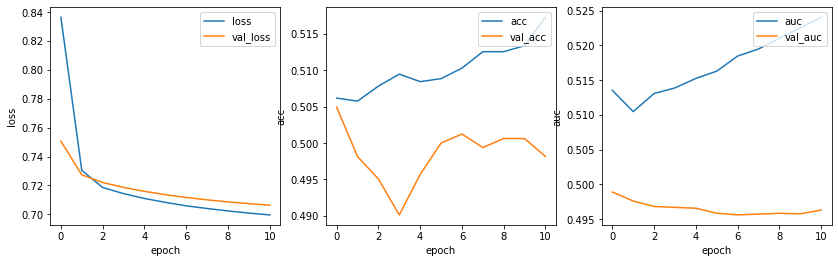

In [20]:
plot_history(history, ['loss', 'acc', 'auc'], figsize=(14,4));

In [21]:
pred_proba_test, pred_test, pred_test_res = eval_metrics(non_rel_mlp)

test set
              precision    recall  f1-score   support

           0       0.99      0.77      0.86    252720
           1       0.01      0.22      0.02      3240

    accuracy                           0.76    255960
   macro avg       0.50      0.49      0.44    255960
weighted avg       0.97      0.76      0.85    255960


test set (balanced via resampling)
              precision    recall  f1-score   support

         0.0       0.50      0.78      0.61      3240
         1.0       0.50      0.22      0.30      3240

    accuracy                           0.50      6480
   macro avg       0.50      0.50      0.46      6480
weighted avg       0.50      0.50      0.46      6480



In [22]:
log_to_wandb(y_test, pred_proba_test, pred_test)

wandb: WARNING wandb uses only 10000 data points to create the plots.


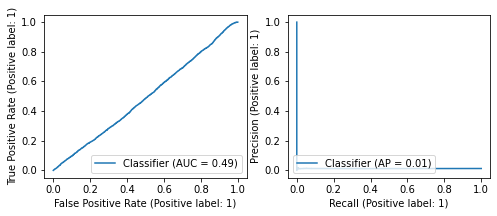

In [23]:
plot_roc_pr_curves(pred_proba_test, y_test);

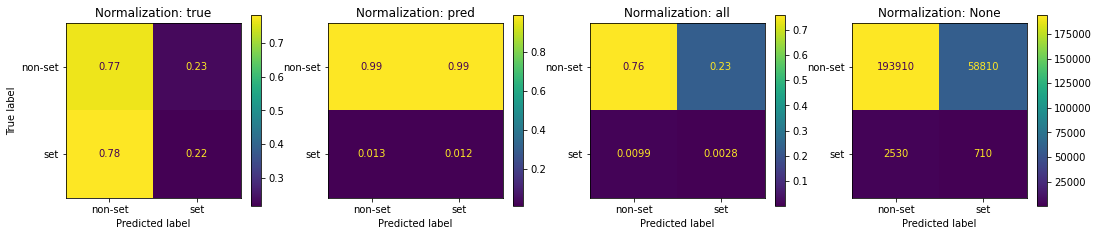

In [24]:
plot_confusion_matrices(y_test, pred_test);

In [25]:
wandb.finish()

### CoRelNet

In [26]:
def create_corelnet_model(n_entities, base_encoding_dim, encoder_constructor, create_classifier, name='CoRelNet'):
    input_ = tf.keras.layers.Input(shape=(n_entities, base_encoding_dim), name='input_entity_seq')

    if encoder_constructor is not None:
        x = EntityEncoder(encoder_constructor, name='encode_entities')(input_)
    else:
        x = input_

    x = RelInnerProduct(name='relation_inner_prod')(x)

    x = tf.keras.layers.Flatten(name='flatten')(x)

    clf = create_classifier()
    x = clf(x)

    corelnet = tf.keras.Model(input_, x, name=name)

    return corelnet


def create_classifier(name='output'):
    clf = tf.keras.Sequential(
        [
            tf.keras.layers.Dense(9, activation='relu'),
            tf.keras.layers.Dense(2, activation='softmax')
        ])

    return clf

#### CoRelNet: No Encoder

In [27]:
encoder_constructor = None

corelnet = create_corelnet_model(n_entities=3, base_encoding_dim=12, encoder_constructor=encoder_constructor, create_classifier=create_classifier)
corelnet.compile(loss=loss, optimizer=opt, metrics=metrics)
corelnet.summary()

Model: "CoRelNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_entity_seq (InputLayer [(None, 3, 12)]           0         
_________________________________________________________________
relation_inner_prod (RelInne (None, 3, 3)              0         
_________________________________________________________________
flatten (Flatten)            (None, 9)                 0         
_________________________________________________________________
sequential (Sequential)      (None, 2)                 110       
Total params: 110
Trainable params: 110
Non-trainable params: 0
_________________________________________________________________


In [28]:
run = wandb.init(project='RelNN', group='CoRelNet (no encoder)', save_code=True)
history = corelnet.fit(train_ds_res, validation_data=val_ds_res, callbacks=create_callbacks(), **fit_kwargs)

Epoch 1/100
38/38 [==============================] - 2s 28ms/step - loss: 0.7187 - acc: 0.4813 - precision: 0.4806 - recall: 0.4630 - auc: 0.5361 - val_loss: 0.6749 - val_acc: 0.4494 - val_precision: 0.4283 - val_recall: 0.3025 - val_auc: 0.6157
Epoch 2/100
38/38 [==============================] - 0s 9ms/step - loss: 0.6753 - acc: 0.4632 - precision: 0.4435 - recall: 0.2889 - auc: 0.6024 - val_loss: 0.6702 - val_acc: 0.4346 - val_precision: 0.4111 - val_recall: 0.3025 - val_auc: 0.6319
Epoch 3/100
38/38 [==============================] - 0s 9ms/step - loss: 0.6686 - acc: 0.4669 - precision: 0.4506 - recall: 0.3021 - auc: 0.6254 - val_loss: 0.6630 - val_acc: 0.4833 - val_precision: 0.4739 - val_recall: 0.3025 - val_auc: 0.6431
Epoch 4/100
38/38 [==============================] - 0s 7ms/step - loss: 0.6635 - acc: 0.4837 - precision: 0.4756 - recall: 0.3169 - auc: 0.6364 - val_loss: 0.6637 - val_acc: 0.5377 - val_precision: 0.5353 - val_recall: 0.5704 - val_auc: 0.6270
Epoch 5/100
38/38 [

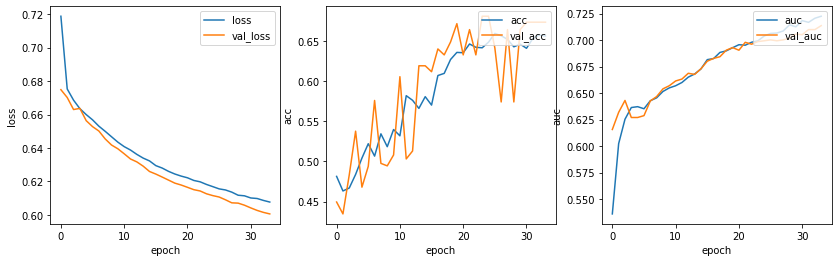

In [29]:
plot_history(history, ['loss', 'acc', 'auc'], figsize=(14,4));

In [30]:
pred_proba_test, pred_test, pred_test_res = eval_metrics(corelnet)

test set
              precision    recall  f1-score   support

           0       0.99      0.78      0.88    252720
           1       0.03      0.61      0.07      3240

    accuracy                           0.78    255960
   macro avg       0.51      0.69      0.47    255960
weighted avg       0.98      0.78      0.87    255960


test set (balanced via resampling)
              precision    recall  f1-score   support

         0.0       0.66      0.78      0.72      3240
         1.0       0.73      0.61      0.66      3240

    accuracy                           0.69      6480
   macro avg       0.70      0.69      0.69      6480
weighted avg       0.70      0.69      0.69      6480



In [31]:
log_to_wandb(y_test, pred_proba_test, pred_test)

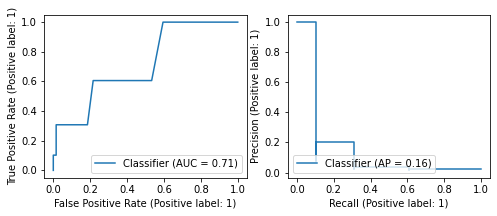

In [32]:
plot_roc_pr_curves(pred_proba_test, y_test);

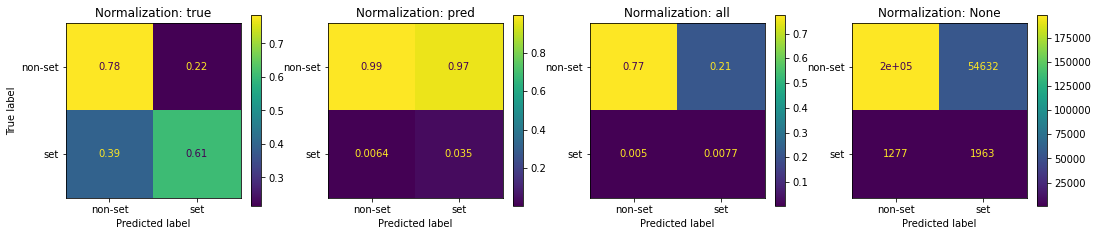

In [33]:
plot_confusion_matrices(y_test, pred_test);

In [34]:
wandb.finish()

#### CoRelNet: MLP Encoder

In [35]:
encoder_constructor = lambda: MLPEncoder([12], activation='relu')

corelnet = create_corelnet_model(n_entities=3, base_encoding_dim=12, encoder_constructor=encoder_constructor, create_classifier=create_classifier)
corelnet.compile(loss=loss, optimizer=opt, metrics=metrics)
corelnet.summary()

Model: "CoRelNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_entity_seq (InputLayer [(None, 3, 12)]           0         
_________________________________________________________________
encode_entities (EntityEncod (None, 3, 12)             156       
_________________________________________________________________
relation_inner_prod (RelInne (None, 3, 3)              0         
_________________________________________________________________
flatten (Flatten)            (None, 9)                 0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 2)                 110       
Total params: 266
Trainable params: 266
Non-trainable params: 0
_________________________________________________________________


In [36]:
run = wandb.init(project='RelNN', group='CoRelNet (MLP encoder)', save_code=True)
history = corelnet.fit(train_ds_res, validation_data=val_ds_res, callbacks=create_callbacks(), **fit_kwargs)

Epoch 1/100
38/38 [==============================] - 7s 170ms/step - loss: 0.7121 - acc: 0.5431 - precision: 0.6471 - recall: 0.1901 - auc: 0.5460 - val_loss: 0.6990 - val_acc: 0.5012 - val_precision: 0.5049 - val_recall: 0.1284 - val_auc: 0.4999
Epoch 2/100
38/38 [==============================] - 6s 147ms/step - loss: 0.6983 - acc: 0.4887 - precision: 0.4657 - recall: 0.1535 - auc: 0.4854 - val_loss: 0.6947 - val_acc: 0.4907 - val_precision: 0.4841 - val_recall: 0.2815 - val_auc: 0.4982
Epoch 3/100
38/38 [==============================] - 5s 134ms/step - loss: 0.6953 - acc: 0.4837 - precision: 0.4772 - recall: 0.3395 - auc: 0.4833 - val_loss: 0.6938 - val_acc: 0.4981 - val_precision: 0.4981 - val_recall: 0.4827 - val_auc: 0.4990
Epoch 4/100
38/38 [==============================] - 6s 148ms/step - loss: 0.6944 - acc: 0.4872 - precision: 0.4888 - recall: 0.5576 - auc: 0.4850 - val_loss: 0.6936 - val_acc: 0.5160 - val_precision: 0.5126 - val_recall: 0.6519 - val_auc: 0.5006
Epoch 5/100


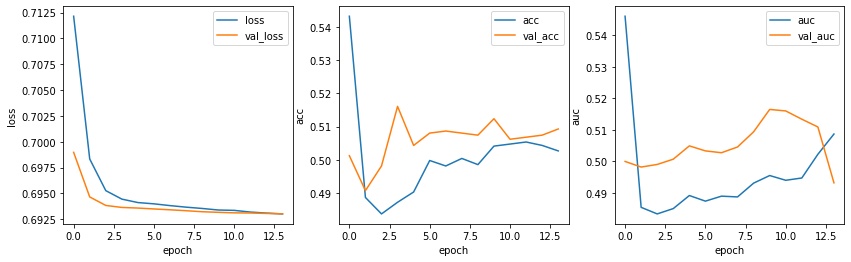

In [37]:
plot_history(history, ['loss', 'acc', 'auc'], figsize=(14,4));

In [38]:
pred_proba_test, pred_test, pred_test_res = eval_metrics(corelnet)

test set
              precision    recall  f1-score   support

           0       0.99      0.37      0.54    252720
           1       0.01      0.65      0.03      3240

    accuracy                           0.37    255960
   macro avg       0.50      0.51      0.28    255960
weighted avg       0.98      0.37      0.53    255960


test set (balanced via resampling)
              precision    recall  f1-score   support

         0.0       0.51      0.36      0.42      3240
         1.0       0.50      0.65      0.57      3240

    accuracy                           0.51      6480
   macro avg       0.51      0.51      0.50      6480
weighted avg       0.51      0.51      0.50      6480



In [39]:
log_to_wandb(y_test, pred_proba_test, pred_test)

wandb: WARNING wandb uses only 10000 data points to create the plots.


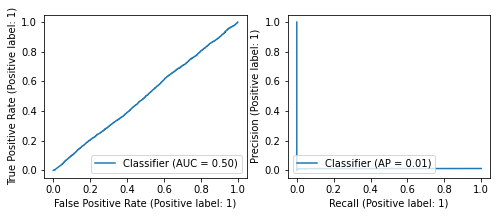

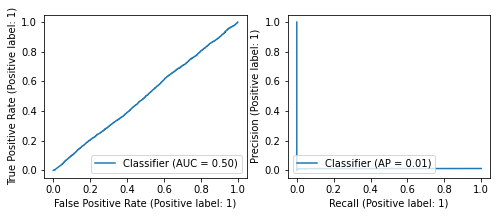

In [40]:
plot_roc_pr_curves(pred_proba_test, y_test);

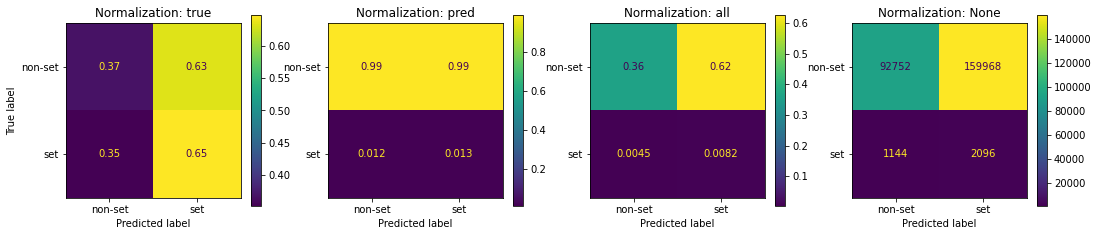

In [41]:
plot_confusion_matrices(y_test, pred_test);

In [23]:
wandb.finish()

### Relational Neural Network (RelNN) [our model]

#### RelNN: Linear Projection Encoders with good initialization of projection spaces

In [24]:
## RelNN with LinearProjectionEncoder
input_ = tf.keras.layers.Input(shape=(3,12), name='input_entity_seq')

encoder_constructors = [LinearProjectionEncoder]*4
rel_layer = RelationalLayer(encoder_constructors, name='rel_layer')
# rel_layer.trainable = False

x = rel_layer(input_)

x = tf.keras.layers.Flatten(name='flatten')(x)

x = tf.keras.layers.Dense(16, activation='relu', name='dense')(x)

x = tf.keras.layers.Dense(2, activation='softmax', name='output')(x)

relnn = tf.keras.models.Model(input_, x, name='relnn')
relnn.summary()

Model: "relnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_entity_seq (InputLayer [(None, 3, 12)]           0         
_________________________________________________________________
rel_layer (RelationalLayer)  (None, 3, 3, 4)           48        
_________________________________________________________________
flatten (Flatten)            (None, 36)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                592       
_________________________________________________________________
output (Dense)               (None, 2)                 34        
Total params: 674
Trainable params: 674
Non-trainable params: 0
_________________________________________________________________


In [25]:
# fix projection vectors
init_proj_vecs = [[1]*3+[0]*9, [0]*3+[1]*3+[0]*6, [0]*6+[1]*3+[0]*3, [0]*9+[1]*3]

for encoder, init_proj_vec in zip(rel_layer.entity_encoders, init_proj_vecs):
    encoder.encoder.weights[0].assign(np.array(init_proj_vec, dtype='float'))

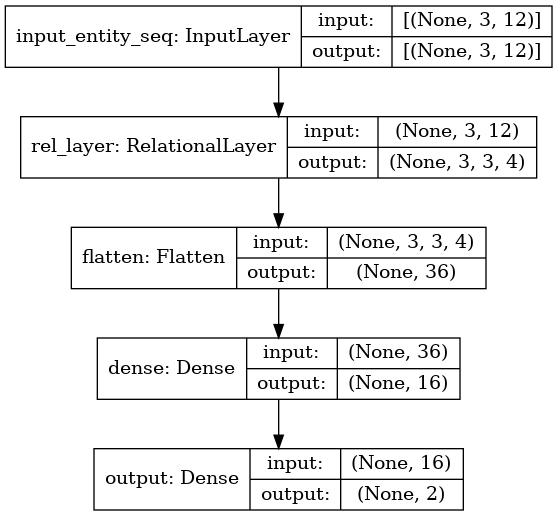

In [26]:
tf.keras.utils.plot_model(relnn, to_file='relnn_architecture.png', expand_nested=True, show_shapes=True)

In [27]:
relnn.compile(
    loss=loss,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=metrics
    )

In [28]:
run = wandb.init(project='RelNN', group='RelNN (Linear Projection, good init)', save_code=True)
history = relnn.fit(X_train_res, y_train_res, validation_data=val_ds_res, callbacks=create_callbacks(), **fit_kwargs)

Epoch 1/100
38/38 [==============================] - 25s 560ms/step - loss: 0.7005 - acc: 0.3549 - precision: 0.2714 - recall: 0.4215 - auc: 0.4035 - val_loss: 0.6966 - val_acc: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5226
Epoch 2/100
38/38 [==============================] - 20s 520ms/step - loss: 0.6951 - acc: 0.5049 - precision: 0.5058 - recall: 0.4325 - auc: 0.5102 - val_loss: 0.6932 - val_acc: 0.5031 - val_precision: 0.5016 - val_recall: 0.9605 - val_auc: 0.5278
Epoch 3/100
38/38 [==============================] - 19s 510ms/step - loss: 0.6951 - acc: 0.5016 - precision: 0.5017 - recall: 0.4724 - auc: 0.5020 - val_loss: 0.6936 - val_acc: 0.5019 - val_precision: 0.5010 - val_recall: 0.9531 - val_auc: 0.5267
Epoch 4/100
38/38 [==============================] - 15s 382ms/step - loss: 0.6937 - acc: 0.5068 - precision: 0.5059 - recall: 0.5819 - auc: 0.5076 - val_loss: 0.6935 - val_acc: 0.5037 - val_precision: 0.5938 - val_recall: 0.0235 - val_auc: 0.5293


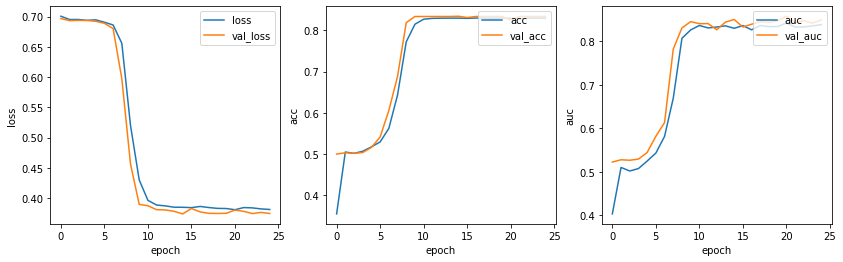

In [29]:
plot_history(history, ['loss', 'acc', 'auc'], figsize=(14,4));

In [30]:
pred_proba_test, pred_test, pred_test_res = eval_metrics(relnn)

test set
              precision    recall  f1-score   support

           0       1.00      0.68      0.81    252720
           1       0.04      1.00      0.07      3240

    accuracy                           0.68    255960
   macro avg       0.52      0.84      0.44    255960
weighted avg       0.99      0.68      0.80    255960


test set (balanced via resampling)
              precision    recall  f1-score   support

         0.0       1.00      0.68      0.81      3240
         1.0       0.76      1.00      0.86      3240

    accuracy                           0.84      6480
   macro avg       0.88      0.84      0.83      6480
weighted avg       0.88      0.84      0.83      6480



In [31]:
log_to_wandb(y_test, pred_proba_test, pred_test)

wandb: WARNING wandb uses only 10000 data points to create the plots.


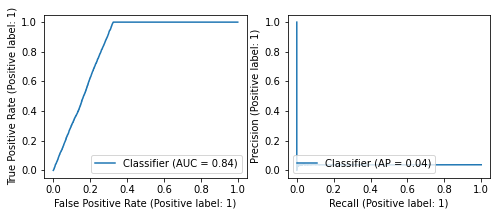

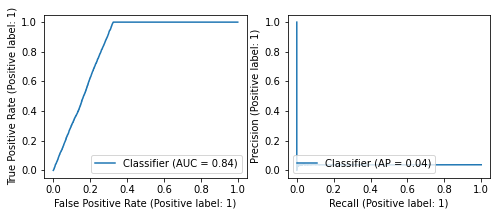

In [32]:
plot_roc_pr_curves(pred_proba_test, y_test);

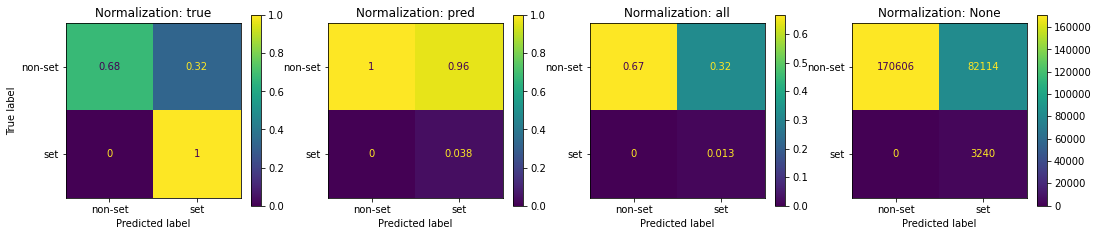

In [33]:
plot_confusion_matrices(y_test, pred_test);

In [34]:
wandb.finish()

#### RelNN: Linear Projection Encoders with randomly initialized projection spaces

In [19]:
## RelNN with LinearProjectionEncoder
input_ = tf.keras.layers.Input(shape=(3,12), name='input_entity_seq')

encoder_constructors = [LinearProjectionEncoder]*4
rel_layer = RelationalLayer(encoder_constructors, name='rel_layer')

x = rel_layer(input_)

x = tf.keras.layers.Flatten(name='flatten')(x)

x = tf.keras.layers.Dense(16, activation='relu', name='dense')(x)

x = tf.keras.layers.Dense(2, activation='softmax', name='output')(x)

relnn = tf.keras.models.Model(input_, x, name='relnn')
relnn.summary()

Model: "relnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_entity_seq (InputLayer [(None, 3, 12)]           0         
_________________________________________________________________
rel_layer (RelationalLayer)  (None, 3, 3, 4)           48        
_________________________________________________________________
flatten (Flatten)            (None, 36)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                592       
_________________________________________________________________
output (Dense)               (None, 2)                 34        
Total params: 674
Trainable params: 674
Non-trainable params: 0
_________________________________________________________________


In [20]:
relnn.compile(
    loss=loss,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=metrics
    )

In [21]:
run = wandb.init(project='RelNN', group='RelNN (Linear Projection)', save_code=True)
history = relnn.fit(X_train_res, y_train_res, validation_data=val_ds_res, callbacks=create_callbacks(), **fit_kwargs)

wandb: Currently logged in as: awni00. Use `wandb login --relogin` to force relogin


2022-10-23 01:09:28.632647: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
38/38 [==============================] - 29s 618ms/step - loss: 0.6793 - acc: 0.5430 - precision: 0.5385 - recall: 0.6016 - auc: 0.5668 - val_loss: 0.6184 - val_acc: 0.6519 - val_precision: 0.6391 - val_recall: 0.6975 - val_auc: 0.7156
Epoch 2/100
38/38 [==============================] - 20s 540ms/step - loss: 0.4980 - acc: 0.7745 - precision: 0.7099 - recall: 0.9284 - auc: 0.8144 - val_loss: 0.3721 - val_acc: 0.8512 - val_precision: 0.7707 - val_recall: 1.0000 - val_auc: 0.8550
Epoch 3/100
38/38 [==============================] - 20s 528ms/step - loss: 0.4029 - acc: 0.8286 - precision: 0.7484 - recall: 0.9901 - auc: 0.8285 - val_loss: 0.3727 - val_acc: 0.8506 - val_precision: 0.7705 - val_recall: 0.9988 - val_auc: 0.8446
Epoch 4/100
38/38 [==============================] - 15s 381ms/step - loss: 0.3862 - acc: 0.8311 - precision: 0.7478 - recall: 0.9992 - auc: 0.8351 - val_loss: 0.3552 - val_acc: 0.8512 - val_precision: 0.7707 - val_recall: 1.0000 - val_auc: 0.8558
Epoch 5/

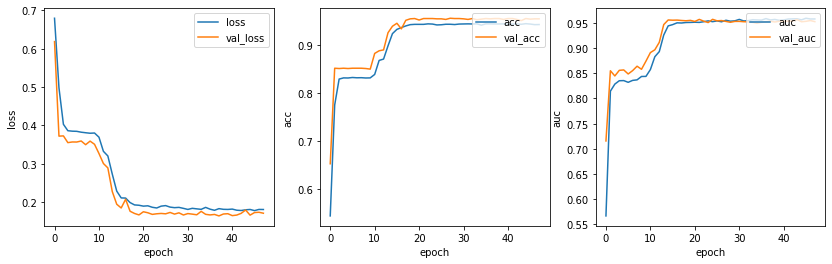

In [22]:
plot_history(history, ['loss', 'acc', 'auc'], figsize=(14,4));

In [23]:
print('test set')
pred_proba_test = relnn(tf.convert_to_tensor(X_test))
pred_test = np.argmax(pred_proba_test, axis=1)
print(sklearn.metrics.classification_report(y_test, pred_test))

print('\ntest set (balanced via resampling)')
pred_test_res = np.argmax(relnn(tf.convert_to_tensor(X_test_res)), axis=1)
print(sklearn.metrics.classification_report(y_test_res[:, 1], pred_test_res))

test set
              precision    recall  f1-score   support

           0       1.00      0.90      0.95    252720
           1       0.11      1.00      0.20      3240

    accuracy                           0.90    255960
   macro avg       0.56      0.95      0.58    255960
weighted avg       0.99      0.90      0.94    255960


test set (balanced via resampling)
              precision    recall  f1-score   support

         0.0       1.00      0.91      0.95      3240
         1.0       0.91      1.00      0.96      3240

    accuracy                           0.95      6480
   macro avg       0.96      0.95      0.95      6480
weighted avg       0.96      0.95      0.95      6480



In [24]:
log_to_wandb(y_test, pred_proba_test, pred_test)

wandb: WARNING wandb uses only 10000 data points to create the plots.


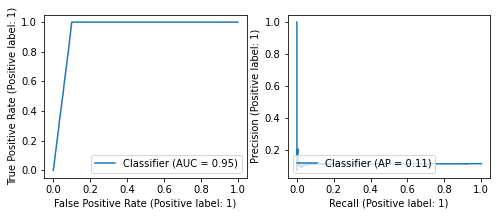

In [25]:
plot_roc_pr_curves(pred_proba_test, y_test);

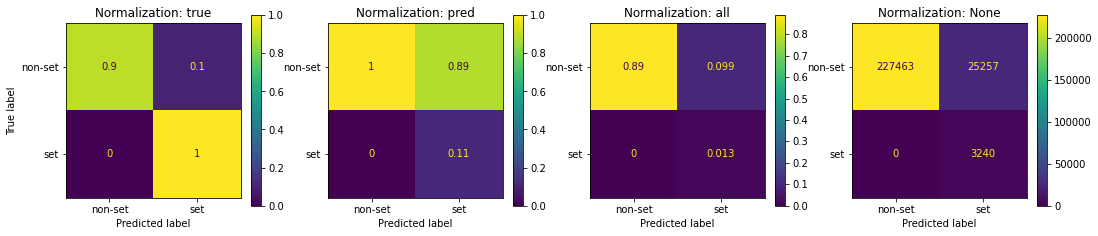

In [26]:
plot_confusion_matrices(y_test, pred_test);

In [27]:
wandb.finish()

### RelNN: MLP Encoder

In [28]:
## RelNN with LinearProjectionEncoder
input_ = tf.keras.layers.Input(shape=(3,12), name='input_entity_seq')

encoder_constructors = [lambda: MLPEncoder(layer_sizes=(4,), activation='relu')]*4
rel_layer = RelationalLayer(encoder_constructors, name='rel_layer')

x = rel_layer(input_)

x = tf.keras.layers.Flatten(name='flatten')(x)

x = tf.keras.layers.Dense(16, activation='relu', name='dense')(x)

x = tf.keras.layers.Dense(2, activation='softmax', name='output')(x)

relnn = tf.keras.models.Model(input_, x, name='relnn')
relnn.summary()

Model: "relnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_entity_seq (InputLayer [(None, 3, 12)]           0         
_________________________________________________________________
rel_layer (RelationalLayer)  (None, 3, 3, 4)           208       
_________________________________________________________________
flatten (Flatten)            (None, 36)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                592       
_________________________________________________________________
output (Dense)               (None, 2)                 34        
Total params: 834
Trainable params: 834
Non-trainable params: 0
_________________________________________________________________


In [29]:
relnn.compile(
    loss=loss,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=metrics
    )

In [30]:
run = wandb.init(project='RelNN', group='RelNN (MLP enc)', save_code=True)
history = relnn.fit(X_train_res, y_train_res, validation_data=val_ds_res, callbacks=create_callbacks(), **fit_kwargs)

Epoch 1/100
38/38 [==============================] - 20s 447ms/step - loss: 0.7461 - acc: 0.6100 - precision: 0.6190 - recall: 0.5725 - auc: 0.6951 - val_loss: 0.6913 - val_acc: 0.5142 - val_precision: 0.5550 - val_recall: 0.1432 - val_auc: 0.5465
Epoch 2/100
38/38 [==============================] - 15s 399ms/step - loss: 0.6887 - acc: 0.5253 - precision: 0.5265 - recall: 0.5037 - auc: 0.5464 - val_loss: 0.6802 - val_acc: 0.5580 - val_precision: 0.6119 - val_recall: 0.3173 - val_auc: 0.6165
Epoch 3/100
38/38 [==============================] - 15s 393ms/step - loss: 0.6252 - acc: 0.6626 - precision: 0.6819 - recall: 0.6095 - auc: 0.7394 - val_loss: 0.4805 - val_acc: 0.8006 - val_precision: 0.7348 - val_recall: 0.9407 - val_auc: 0.8547
Epoch 4/100
38/38 [==============================] - 15s 407ms/step - loss: 0.3816 - acc: 0.8562 - precision: 0.7969 - recall: 0.9560 - auc: 0.8834 - val_loss: 0.3057 - val_acc: 0.8944 - val_precision: 0.8332 - val_recall: 0.9864 - val_auc: 0.9122
Epoch 5/

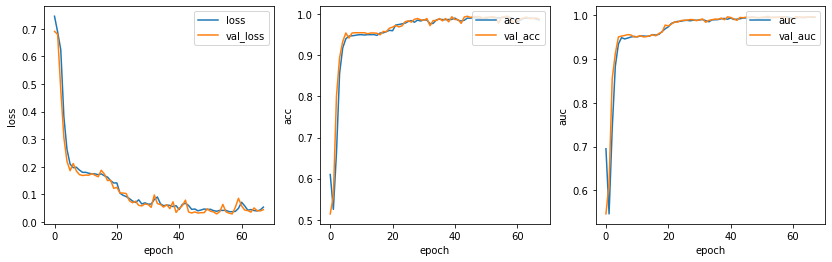

In [31]:
plot_history(history, ['loss', 'acc', 'auc'], figsize=(14,4));

In [32]:
print('test set')
pred_proba_test = relnn(tf.convert_to_tensor(X_test))
pred_test = np.argmax(pred_proba_test, axis=1)
print(sklearn.metrics.classification_report(y_test, pred_test))

print('\ntest set (balanced via resampling)')
pred_test_res = np.argmax(relnn(tf.convert_to_tensor(X_test_res)), axis=1)
print(sklearn.metrics.classification_report(y_test_res[:, 1], pred_test_res))

test set
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    252720
           1       0.42      1.00      0.60      3240

    accuracy                           0.98    255960
   macro avg       0.71      0.99      0.79    255960
weighted avg       0.99      0.98      0.99    255960


test set (balanced via resampling)
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99      3240
         1.0       0.98      1.00      0.99      3240

    accuracy                           0.99      6480
   macro avg       0.99      0.99      0.99      6480
weighted avg       0.99      0.99      0.99      6480



In [33]:
log_to_wandb(y_test, pred_proba_test, pred_test)

wandb: WARNING wandb uses only 10000 data points to create the plots.


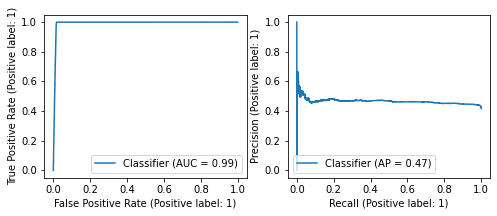

In [34]:
plot_roc_pr_curves(pred_proba_test, y_test);

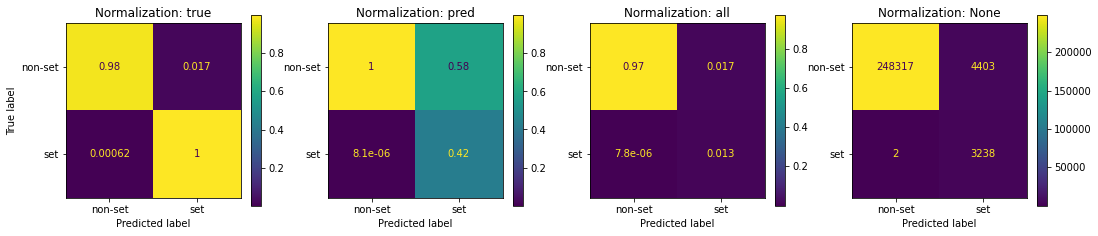

In [35]:
plot_confusion_matrices(y_test, pred_test);

In [36]:
wandb.finish()

## Notes

**Observations:**
- (O1) RelNN sometimes gets stuck at high loss for a while and then finds a way to escape it during training. (Note: used Adam on RelNN's instead of SGD because of this!)
- (O2) CoRelNet without an encoder was able to predict 'setness' with better than random accuracy. No encoder performed better than with an MLP encoder. (results on one trial, won't necessarily generalize)
- (O3) In these particular experiments, all versions of RelNN performed better than CoRelNet (and non-relational model). Good initialization of projection subspaces did not improve over learning from random initialization. MLP encoder model performed best, with near perfect accuracy on balanced test set.

**To-Do's:**
- (TD1) come up with systematic experimental methodology to run broader set of experiments on. decide how to handle class imbalance. run several trials for each.
- (TD2) CoRelNet (and other ESBN) use TCN. read paper. add TCN to experiments and observe effects.
- (TD3) add spurious features. observe effect on each set of models.
- (TD4) implement grouping layer and test on appropriate task (e.g.: ABA task, etc.)

**Questions:**
- (Q1) why can CoRelNet predict?
    - with the encoding we're using, each pairwise relation is the number of attributes shared by the two entities. is this enough to predict 'setness'? compute the set of relation matrices for all sets and non-sets and see if there is an example both sets and non-sets have the same relation matrix...
- (Q2) how do linear projection vs MLP encoders compare?
- (Q3) what effect exactly did the 'good initialization' of the linear projection spaces have on RelNN?
- (Q4) on O1: is there anything we can infer about the loss landscape for such models that might explain this?
